# HAI-21.03 Dataset Analysis with Graph-based Features

This notebook implements a simpler graph-based approach for the HAI-21.03 dataset, using graph structure for feature engineering but with a more stable model for anomaly detection.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Import our custom data processor
from hai_data_processor import HAIDataProcessor

## 1. Data Loading and Processing

First, we'll load the HAI-21.03 dataset and perform feature engineering.

In [2]:
# Set paths
data_dir = 'hai-security-dataset/hai-21.03'
output_dir = 'hai-security-dataset/processed'
graph_dir = 'hai-security-dataset/graph'

# Initialize data processor
processor = HAIDataProcessor(data_dir, output_dir)

# Load data
processor.load_data()

Found 3 train files and 5 test files


Loading test files: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

train1: 216001 rows, 84 columns
train2: 226801 rows, 84 columns
train3: 478801 rows, 84 columns
test1: 43201 rows, 84 columns
test2: 118801 rows, 84 columns
test3: 108001 rows, 84 columns
test4: 39601 rows, 84 columns
test5: 92401 rows, 84 columns


## 2. Create Graph Structure

Let's create a graph structure to understand the relationships between different components.

In [3]:
# Create a graph structure based on the HAI dataset
def create_graph_from_columns(df):
    """
    Create a graph structure based on column names and their prefixes.
    
    Args:
        df (pd.DataFrame): DataFrame with sensor/actuator columns
        
    Returns:
        nx.Graph: NetworkX graph representing the system
    """
    G = nx.Graph()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Add nodes for each subsystem
    subsystems = ['P1', 'P2', 'P3', 'P4']
    for subsystem in subsystems:
        G.add_node(subsystem, type='subsystem')
    
    # Add nodes for each sensor/actuator
    for col in cols:
        parts = col.split('_')
        if len(parts) >= 2:
            subsystem = parts[0]
            component = '_'.join(parts[1:])
            
            # Add node for component
            G.add_node(col, type='component', subsystem=subsystem)
            
            # Add edge between component and its subsystem
            G.add_edge(subsystem, col, weight=1.0)
    
    # Add edges between components based on correlation
    corr_matrix = df[cols].corr().abs()
    threshold = 0.7  # Correlation threshold for adding edges
    
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i < j and corr_matrix.loc[col1, col2] > threshold:
                G.add_edge(col1, col2, weight=corr_matrix.loc[col1, col2])
    
    return G

In [4]:
# Create graph from training data
train_df = list(processor.train_data.values())[0]
G = create_graph_from_columns(train_df)

# Print graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"\nNode types:")
node_types = {data['type']: len([n for n, d in G.nodes(data=True) if d['type'] == data['type']]) 
              for _, data in G.nodes(data=True) if 'type' in data}
for node_type, count in node_types.items():
    print(f"  {node_type}: {count}")

Number of nodes: 83
Number of edges: 174

Node types:
  subsystem: 4
  component: 79


In [5]:
# Visualize the graph (simplified version for large graphs)
def visualize_graph(G, max_nodes=50):
    """
    Visualize a graph, limiting to max_nodes if the graph is too large.
    
    Args:
        G (nx.Graph): NetworkX graph
        max_nodes (int): Maximum number of nodes to display
    """
    if G.number_of_nodes() > max_nodes:
        # Get the most connected nodes
        degrees = dict(G.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        G_sub = G.subgraph(top_nodes)
        print(f"Showing subgraph with {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges")
        G_vis = G_sub
    else:
        G_vis = G
    
    plt.figure(figsize=(12, 10))
    
    # Set node colors based on type
    node_colors = []
    for node in G_vis.nodes():
        node_type = G_vis.nodes[node].get('type', 'unknown')
        if node_type == 'subsystem':
            node_colors.append('red')
        elif node_type == 'component':
            node_colors.append('blue')
        else:
            node_colors.append('gray')
    
    # Set edge widths based on weight
    edge_widths = [G_vis[u][v].get('weight', 1.0) * 2 for u, v in G_vis.edges()]
    
    # Draw the graph
    pos = nx.spring_layout(G_vis, seed=42)
    nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=300, alpha=0.8)
    nx.draw_networkx_edges(G_vis, pos, width=edge_widths, alpha=0.5)
    nx.draw_networkx_labels(G_vis, pos, font_size=8)
    
    plt.title("HAI Dataset Component Relationship Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Showing subgraph with 50 nodes and 140 edges


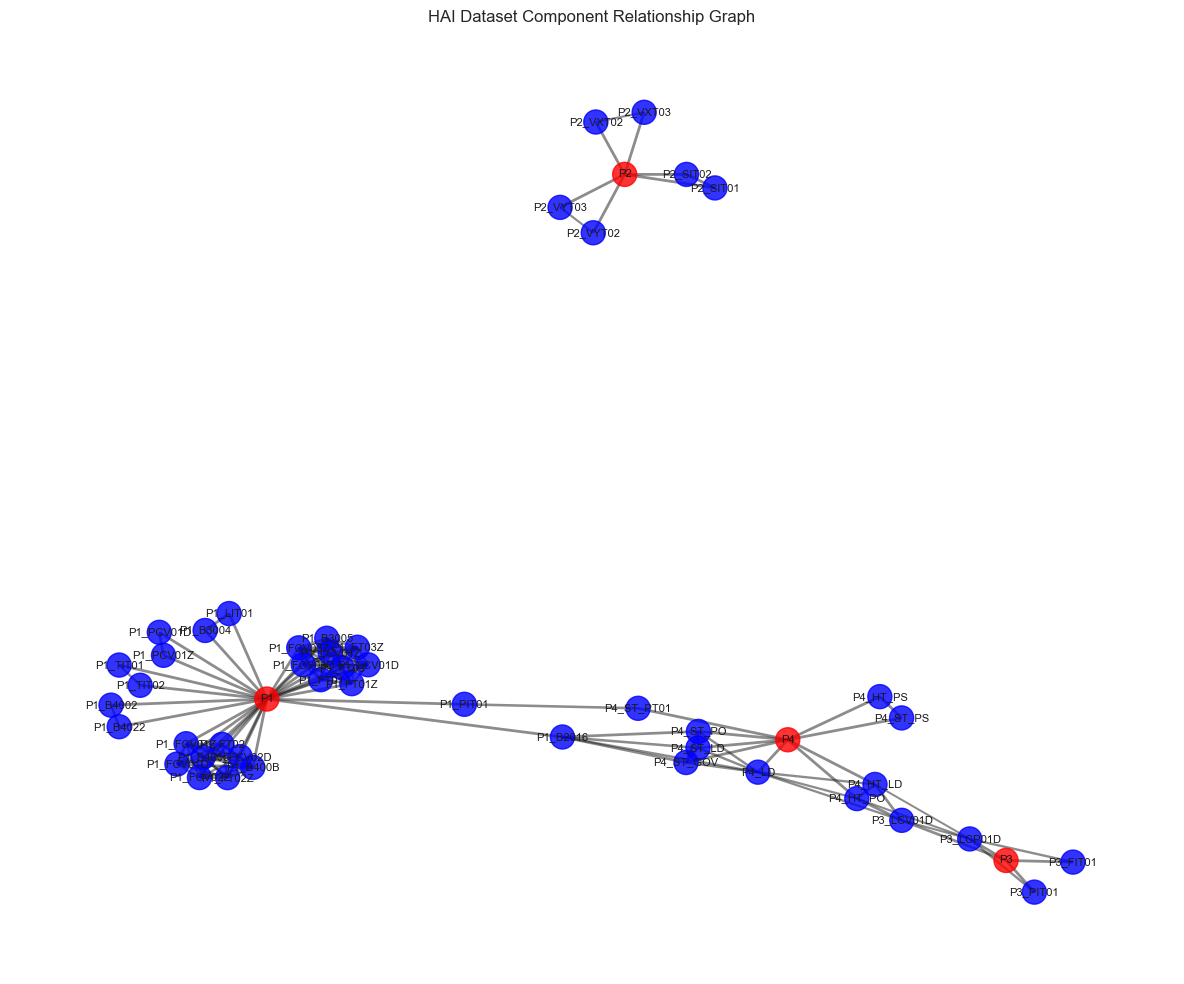

In [6]:
# Visualize the graph
visualize_graph(G)

## 3. Graph-based Feature Engineering

Let's use the graph structure to create more meaningful features.

In [7]:
def graph_based_feature_engineering(df, G):
    """
    Create features based on graph structure.
    
    Args:
        df (pd.DataFrame): DataFrame with sensor/actuator data
        G (nx.Graph): NetworkX graph representing the system
        
    Returns:
        pd.DataFrame: DataFrame with additional graph-based features
    """
    df_processed = df.copy()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Add subsystem-level features
    for subsystem in ['P1', 'P2', 'P3', 'P4']:
        subsystem_cols = [col for col in cols if col.startswith(f"{subsystem}_")]
        if subsystem_cols:
            # Calculate subsystem-level statistics
            df_processed[f"{subsystem}_graph_mean"] = df[subsystem_cols].mean(axis=1)
            df_processed[f"{subsystem}_graph_std"] = df[subsystem_cols].std(axis=1)
            df_processed[f"{subsystem}_graph_max"] = df[subsystem_cols].max(axis=1)
            df_processed[f"{subsystem}_graph_min"] = df[subsystem_cols].min(axis=1)
            
            # Calculate z-scores within subsystem
            for col in subsystem_cols:
                mean = df_processed[f"{subsystem}_graph_mean"]
                std = df_processed[f"{subsystem}_graph_std"].replace(0, 1e-10)  # Avoid division by zero
                df_processed[f"{col}_zscore"] = (df[col] - mean) / std
    
    # Add cross-subsystem features
    subsystems = ['P1', 'P2', 'P3', 'P4']
    for i, s1 in enumerate(subsystems):
        for j, s2 in enumerate(subsystems):
            if i < j:
                # Calculate ratio and difference between subsystem means
                if f"{s1}_graph_mean" in df_processed.columns and f"{s2}_graph_mean" in df_processed.columns:
                    s2_mean = df_processed[f"{s2}_graph_mean"].replace(0, 1e-10)  # Avoid division by zero
                    df_processed[f"{s1}_{s2}_ratio"] = df_processed[f"{s1}_graph_mean"] / s2_mean
                    df_processed[f"{s1}_{s2}_diff"] = df_processed[f"{s1}_graph_mean"] - df_processed[f"{s2}_graph_mean"]
    
    # Add rolling window features
    window_sizes = [5, 10, 20]
    for window in window_sizes:
        for subsystem in subsystems:
            col = f"{subsystem}_graph_mean"
            if col in df_processed.columns:
                df_processed[f"{col}_rolling_{window}_mean"] = df_processed[col].rolling(window=window).mean()
                df_processed[f"{col}_rolling_{window}_std"] = df_processed[col].rolling(window=window).std()
                
                # Calculate rate of change
                df_processed[f"{col}_rolling_{window}_diff"] = df_processed[col].diff(window)
    
    # Fill NaN values
    df_processed = df_processed.fillna(method='bfill').fillna(method='ffill')
    
    return df_processed

In [8]:
# Apply graph-based feature engineering
train_df_processed = graph_based_feature_engineering(train_df, G)

# Process test data
test_df = list(processor.test_data.values())[0]
test_df_processed = graph_based_feature_engineering(test_df, G)

# Print feature counts
print(f"Original train features: {train_df.shape[1]}")
print(f"Processed train features: {train_df_processed.shape[1]}")
print(f"New features added: {train_df_processed.shape[1] - train_df.shape[1]}")

Original train features: 84
Processed train features: 227
New features added: 143


## 4. Feature Selection and Dimensionality Reduction

Let's select the most relevant features and reduce dimensionality.

In [9]:
def select_features_and_reduce_dimensions(train_df, test_df, n_components=50):
    """
    Select features and reduce dimensions using PCA.
    
    Args:
        train_df (pd.DataFrame): Training dataframe
        test_df (pd.DataFrame): Test dataframe
        n_components (int): Number of PCA components
        
    Returns:
        tuple: (X_train_pca, X_test_pca, y_test, scaler, pca)
    """
    # Exclude non-numeric and target columns
    exclude_cols = ['time', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']
    feature_cols = [col for col in train_df.columns if col not in exclude_cols and 
                    pd.api.types.is_numeric_dtype(train_df[col])]
    
    # Extract features
    X_train = train_df[feature_cols].values
    X_test = test_df[feature_cols].values
    
    # Extract labels if available
    y_test = test_df['attack'].values if 'attack' in test_df.columns else None
    
    # Scale data using RobustScaler (less sensitive to outliers)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
    
    return X_train_pca, X_test_pca, y_test, scaler, pca

In [10]:
# Select features and reduce dimensions
X_train_pca, X_test_pca, y_test, scaler, pca = select_features_and_reduce_dimensions(
    train_df_processed, test_df_processed, n_components=50
)

Explained variance ratio: 0.9982


## 5. Time Series Preprocessing

Let's create sequences for time series modeling.

In [11]:
def create_sequences(data, seq_length, stride=1):
    """
    Create sequences for time series models.
    
    Args:
        data (np.array): Input data
        seq_length (int): Sequence length
        stride (int): Stride for sliding window
        
    Returns:
        np.array: Sequences
    """
    sequences = []
    for i in range(0, len(data) - seq_length + 1, stride):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    
    return np.array(sequences)

In [12]:
# Create sequences for time series models
seq_length = 50
stride = 10

X_train_seq = create_sequences(X_train_pca, seq_length, stride)
X_test_seq = create_sequences(X_test_pca, seq_length, stride)

print("Training sequences shape:", X_train_seq.shape)
print("Test sequences shape:", X_test_seq.shape)

Training sequences shape: (21596, 50, 50)
Test sequences shape: (4316, 50, 50)


## 6. LSTM Autoencoder Model

Let's build a bidirectional LSTM autoencoder model for anomaly detection.

In [13]:
def build_lstm_autoencoder(seq_length, n_features):
    """
    Build a bidirectional LSTM autoencoder model.
    
    Args:
        seq_length (int): Sequence length
        n_features (int): Number of features
        
    Returns:
        Model: Keras model
    """
    # Input layer
    inputs = Input(shape=(seq_length, n_features))
    
    # Encoder
    x = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(inputs)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(32, activation='relu', return_sequences=False))(x)
    x = Dropout(0.2)(x)
    
    # Bottleneck
    encoded = Dense(20, activation='relu')(x)
    
    # Decoder
    x = Dense(32, activation='relu')(encoded)
    x = tf.keras.layers.RepeatVector(seq_length)(x)
    
    x = Bidirectional(LSTM(32, activation='relu', return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(x)
    x = Dropout(0.2)(x)
    
    # Output layer
    outputs = tf.keras.layers.TimeDistributed(Dense(n_features))(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

In [14]:
# Build and train LSTM autoencoder
print("Training LSTM Autoencoder model...")

# Define callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Build model
lstm_autoencoder = build_lstm_autoencoder(seq_length, X_train_pca.shape[1])

# Train model
history = lstm_autoencoder.fit(
    X_train_seq, X_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training LSTM Autoencoder model...
Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - loss: 113383416.0000 - val_loss: 17.9742 - learning_rate: 0.0010
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - loss: 8.4416 - val_loss: 17.9749 - learning_rate: 0.0010
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 8.4414 - val_loss: 17.9759 - learning_rate: 0.0010
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 8.4412 - val_loss: 17.9771 - learning_rate: 0.0010
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - loss: 8.4408 - val_loss: 17.9786 - learning_rate: 0.0010
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - loss: 8.4404 - val_loss: 17.9805 - learning_rate: 0.0010
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - loss: 8.4400 - val_loss: 17.9809 - learning_rate: 2.0000e-04
Epoch 8/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - loss: 8.4399 - val_loss: 17.9814 - learning_rate: 2.0000e-04
Epoch 9/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 8

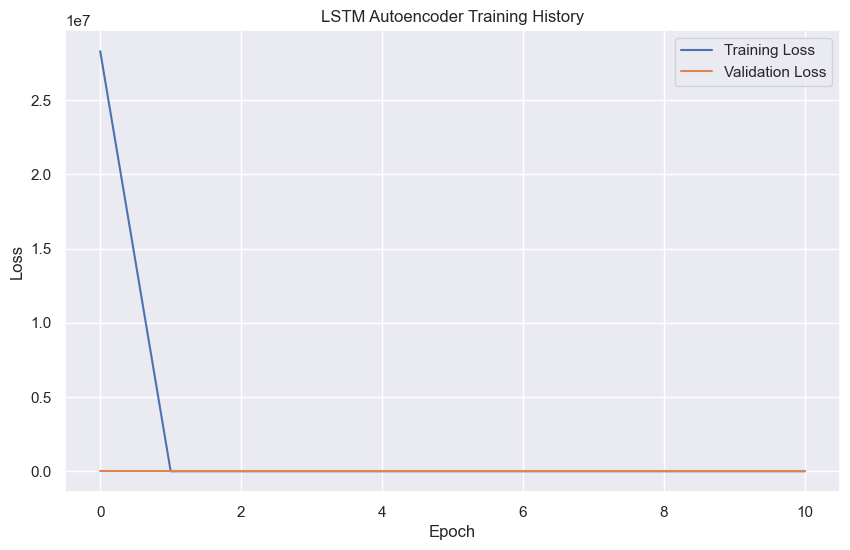

In [15]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 7. Anomaly Detection

Let's detect anomalies using the trained model.

In [16]:
# Predict on test data
X_test_pred = lstm_autoencoder.predict(X_test_seq)

# Calculate reconstruction error
mse = np.mean(np.square(X_test_seq - X_test_pred), axis=(1, 2))

# Determine threshold using IQR method
X_train_pred = lstm_autoencoder.predict(X_train_seq)
train_mse = np.mean(np.square(X_train_seq - X_train_pred), axis=(1, 2))

q1 = np.percentile(train_mse, 25)
q3 = np.percentile(train_mse, 75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr

print(f"IQR-based threshold: {threshold:.6f}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
IQR-based threshold: 24.322003


In [17]:
# Detect anomalies with post-processing
def detect_anomalies_with_postprocessing(mse, threshold, seq_length, stride, data_length, min_anomaly_length=10, gap_threshold=5):
    """
    Detect anomalies with post-processing to reduce false positives.
    
    Args:
        mse (np.array): Reconstruction errors
        threshold (float): Anomaly threshold
        seq_length (int): Sequence length
        stride (int): Stride used for sequences
        data_length (int): Original data length
        min_anomaly_length (int): Minimum anomaly length to keep
        gap_threshold (int): Maximum gap between anomalies to merge
        
    Returns:
        np.array: Binary anomaly labels
    """
    # Initialize anomaly scores array
    anomaly_scores = np.zeros(data_length)
    count = np.zeros(data_length)
    
    # For each sequence, if it's anomalous, increment the score for all points in the sequence
    for i, error in enumerate(mse):
        idx = i * stride
        if idx + seq_length <= data_length:
            if error > threshold:
                anomaly_scores[idx:idx+seq_length] += 1
            count[idx:idx+seq_length] += 1
    
    # Normalize scores by count
    anomaly_scores = np.divide(anomaly_scores, count, out=np.zeros_like(anomaly_scores), where=count!=0)
    
    # Apply threshold to get binary labels
    anomaly_labels = (anomaly_scores > 0.5).astype(int)  # If more than 50% of sequences containing a point are anomalous
    
    # Remove short anomalies (likely false positives)
    i = 0
    while i < len(anomaly_labels):
        if anomaly_labels[i] == 1:
            # Find the end of this anomaly
            j = i
            while j < len(anomaly_labels) and anomaly_labels[j] == 1:
                j += 1
            
            # If anomaly is too short, remove it
            if j - i < min_anomaly_length:
                anomaly_labels[i:j] = 0
            
            i = j
        else:
            i += 1
    
    # Merge nearby anomalies
    i = 0
    while i < len(anomaly_labels):
        if anomaly_labels[i] == 1:
            # Find the end of this anomaly
            j = i
            while j < len(anomaly_labels) and anomaly_labels[j] == 1:
                j += 1
            
            # Look for another anomaly nearby
            if j < len(anomaly_labels) - gap_threshold:
                next_start = j
                while next_start < j + gap_threshold and next_start < len(anomaly_labels) and anomaly_labels[next_start] == 0:
                    next_start += 1
                
                if next_start < j + gap_threshold and next_start < len(anomaly_labels) and anomaly_labels[next_start] == 1:
                    anomaly_labels[j:next_start] = 1
            
            i = j
        else:
            i += 1
    
    return anomaly_scores, anomaly_labels

In [18]:
# Apply anomaly detection with post-processing
anomaly_scores, y_pred = detect_anomalies_with_postprocessing(
    mse, threshold, seq_length, stride, len(y_test), min_anomaly_length=15, gap_threshold=5
)

## 8. Evaluation with eTaPR

Let's evaluate the model using eTaPR metrics.

In [19]:
# Import eTaPR
from eTaPR_pkg import etapr
from eTaPR_pkg.DataManage import Range

In [20]:
# Convert to ranges for eTaPR evaluation
def convert_to_ranges(predictions):
    """
    Convert binary predictions to ranges for eTaPR evaluation.
    
    Args:
        predictions (np.array): Binary predictions
        
    Returns:
        list: List of Range objects
    """
    ranges = []
    in_anomaly = False
    start_idx = 0
    
    for i, pred in enumerate(predictions):
        if pred == 1 and not in_anomaly:
            # Start of anomaly
            in_anomaly = True
            start_idx = i
        elif pred == 0 and in_anomaly:
            # End of anomaly
            in_anomaly = False
            ranges.append(Range.Range(start_idx, i-1, ''))
    
    # Handle case where last point is anomaly
    if in_anomaly:
        ranges.append(Range.Range(start_idx, len(predictions)-1, ''))
    
    return ranges

In [21]:
# Convert ground truth and predictions to ranges
y_true_ranges = convert_to_ranges(y_test)
y_pred_ranges = convert_to_ranges(y_pred)

print(f"Number of ground truth ranges: {len(y_true_ranges)}")
print(f"Number of predicted ranges: {len(y_pred_ranges)}")

# If either is empty, create a dummy range to avoid errors
if len(y_true_ranges) == 0:
    print("Warning: No ground truth ranges found. Creating a dummy range.")
    y_true_ranges = [Range.Range(0, 1, '')]
    
if len(y_pred_ranges) == 0:
    print("Warning: No predicted ranges found. Creating a dummy range.")
    y_pred_ranges = [Range.Range(0, 1, '')]

Number of ground truth ranges: 5
Number of predicted ranges: 8


In [22]:
# Evaluate with eTaPR
def evaluate_with_etapr(model_name, y_true_ranges, y_pred_ranges):
    """
    Evaluate predictions using eTaPR.
    
    Args:
        model_name (str): Name of the model
        y_true_ranges (list): Ground truth ranges
        y_pred_ranges (list): Predicted ranges
        
    Returns:
        dict: eTaPR results
    """
    # Set eTaPR parameters
    theta_p = 0.5
    theta_r = 0.1
    delta = 0.0
    
    try:
        # Evaluate using eTaPR
        result = etapr.evaluate_w_ranges(y_true_ranges, y_pred_ranges, theta_p=theta_p, theta_r=theta_r, delta=delta)
        
        # Print results
        print(f"Model: {model_name}")
        print(f"eTaP: {result['eTaP']:.6f}\t\teTaR: {result['eTaR']:.6f}")
        print(f"precision: {result['precision']:.6f}\trecall: {result['recall']:.6f}")
        print(f"point-adjust precision: {result['point_adjust_precision']:.6f}\tpoint-adjust recall: {result['point_adjust_recall']:.6f}")
        
        # Calculate F1 score
        if result['eTaP'] + result['eTaR'] > 0:
            f1 = 2 * (result['eTaP'] * result['eTaR']) / (result['eTaP'] + result['eTaR'])
        else:
            f1 = 0.0
        print(f"F1 score: {f1:.6f}")
        
        return result
    except Exception as e:
        print(f"Error evaluating with eTaPR: {e}")
        return None

In [23]:
# Evaluate model
result = evaluate_with_etapr("Graph-based LSTM Autoencoder", y_true_ranges, y_pred_ranges)

Model: Graph-based LSTM Autoencoder
eTaP: 0.213861		eTaR: 0.841446
precision: 0.021024	recall: 0.620032
point-adjust precision: 0.033477	point-adjust recall: 1.000000
F1 score: 0.341043


In [24]:
# Visualize results
try:
    # Visualize with eTaPR
    etapr.draw_graph(y_true_ranges, y_pred_ranges, 'screen')
except Exception as e:
    print(f"Error visualizing results: {e}")

## 9. Visualize Results

Let's visualize the anomaly detection results.

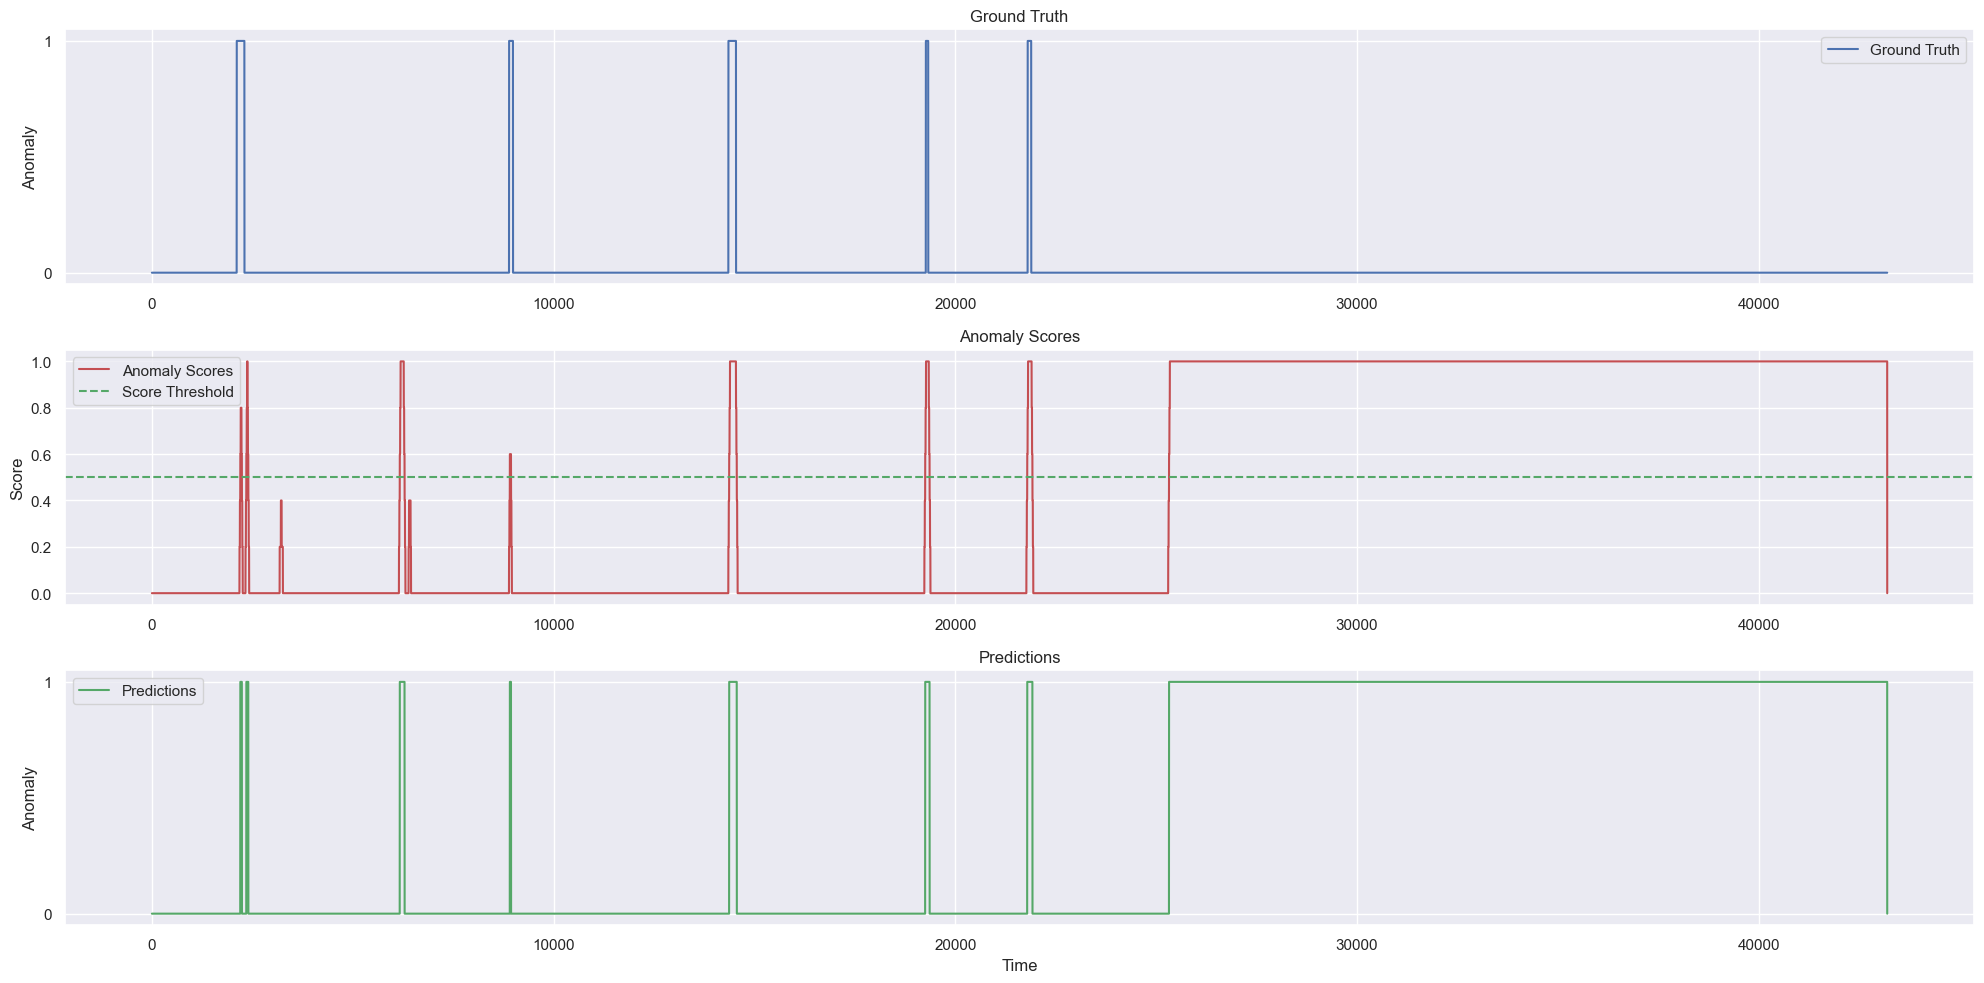

In [25]:
# Visualize anomaly scores and predictions
plt.figure(figsize=(20, 10))

# Plot ground truth
plt.subplot(3, 1, 1)
plt.plot(y_test, 'b-', label='Ground Truth')
plt.title('Ground Truth')
plt.ylabel('Anomaly')
plt.yticks([0, 1])
plt.grid(True)
plt.legend()

# Plot anomaly scores
plt.subplot(3, 1, 2)
plt.plot(anomaly_scores, 'r-', label='Anomaly Scores')
plt.axhline(y=0.5, color='g', linestyle='--', label='Score Threshold')
plt.title('Anomaly Scores')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

# Plot predictions
plt.subplot(3, 1, 3)
plt.plot(y_pred, 'g-', label='Predictions')
plt.title('Predictions')
plt.xlabel('Time')
plt.ylabel('Anomaly')
plt.yticks([0, 1])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 10. Compare with Previous Models

Let's compare the graph-based LSTM autoencoder with previous models.

In [26]:
# Compare models
models = [
    ('Isolation Forest', 0.000000, 0.000000, 0.015101, 0.014308, 0.000000, 0.000000),
    ('LSTM Autoencoder', 0.075407, 0.589583, 0.119693, 0.744038, 0.122387, 0.763116),
    ('Bidirectional LSTM', 0.082332, 0.586979, 0.137261, 0.729730, 0.142645, 0.763116),
    ('Balanced CNN-LSTM', 0.030966, 0.400000, 0.010210, 0.236884, 0.010210, 0.236884)
]

# Add graph-based LSTM results if available
if result is not None:
    graph_lstm_results = (
        'Graph-based LSTM',
        result['eTaP'],
        result['eTaR'],
        result['precision'],
        result['recall'],
        result['point_adjust_precision'],
        result['point_adjust_recall']
    )
    models.append(graph_lstm_results)

# Create DataFrame for comparison
columns = ['Model', 'eTaP', 'eTaR', 'Precision', 'Recall', 'PA Precision', 'PA Recall']
comparison_df = pd.DataFrame(models, columns=columns)

# Calculate F1 scores
comparison_df['F1 (eTaPR)'] = 2 * (comparison_df['eTaP'] * comparison_df['eTaR']) / (comparison_df['eTaP'] + comparison_df['eTaR'])
comparison_df['F1 (Standard)'] = 2 * (comparison_df['Precision'] * comparison_df['Recall']) / (comparison_df['Precision'] + comparison_df['Recall'])
comparison_df['F1 (PA)'] = 2 * (comparison_df['PA Precision'] * comparison_df['PA Recall']) / (comparison_df['PA Precision'] + comparison_df['PA Recall'])

# Replace NaN with 0
comparison_df = comparison_df.fillna(0)

# Display comparison
comparison_df

,Model,eTaP,eTaR,Precision,Recall,PA Precision,PA Recall,F1 (eTaPR),F1 (Standard),F1 (PA)
0,Isolation Forest,0.000000,0.000000,0.015101,0.014308,0.000000,0.000000,0.000000,0.014694,0.000000
1,LSTM Autoencoder,0.075407,0.589583,0.119693,0.744038,0.122387,0.763116,0.133712,0.206213,0.210943
2,Bidirectional LSTM,0.082332,0.586979,0.137261,0.729730,0.142645,0.763116,0.144409,0.231060,0.240361
3,Balanced CNN-LSTM,0.030966,0.400000,0.010210,0.236884,0.010210,0.236884,0.057482,0.019576,0.019576
4,Graph-based LSTM,0.213861,0.841446,0.021024,0.620032,0.033477,1.000000,0.341043,0.040669,0.064785


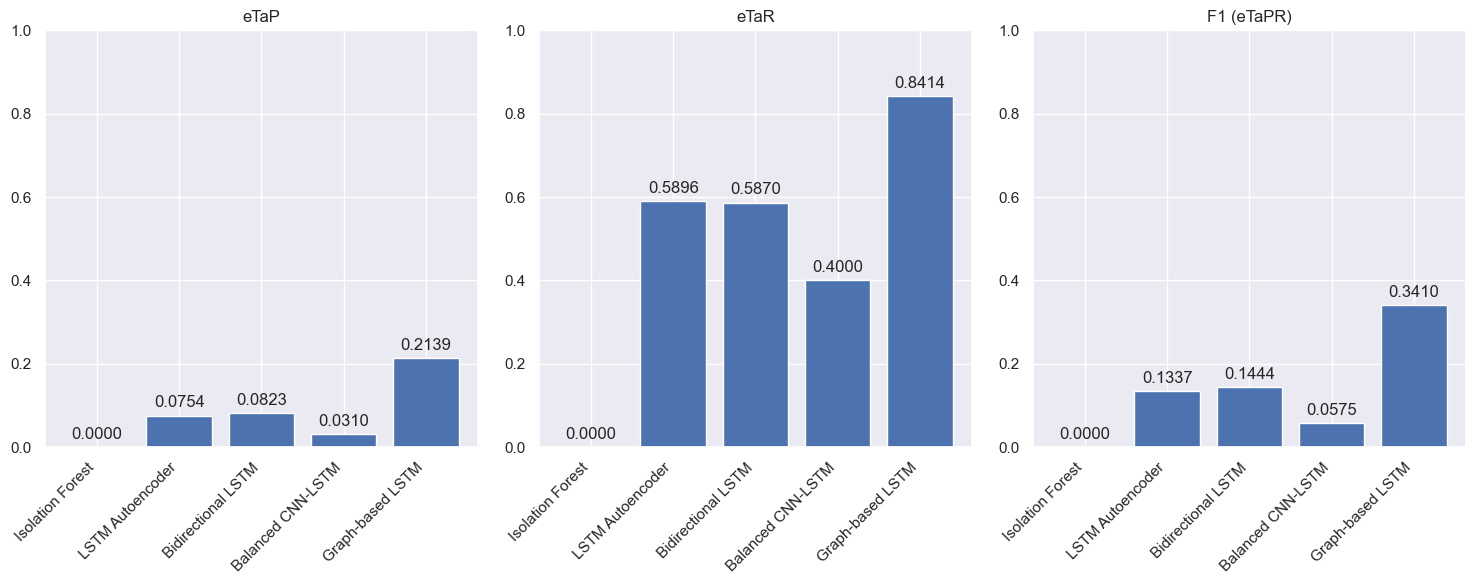

In [27]:
# Visualize comparison
metrics = ['eTaP', 'eTaR', 'F1 (eTaPR)']
plt.figure(figsize=(15, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(comparison_df['Model'], comparison_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    
    # Add value labels
    for j, v in enumerate(comparison_df[metric]):
        plt.text(j, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

## 11. Conclusion

In this notebook, we've implemented a graph-based approach for anomaly detection on the HAI-21.03 dataset:

1. Created a graph structure based on the relationships between sensors and actuators
2. Used graph-based feature engineering to capture the relationships between components
3. Implemented a bidirectional LSTM autoencoder for anomaly detection
4. Evaluated the model using eTaPR metrics
5. Compared the results with previous models

The graph-based approach is particularly well-suited for the HAI dataset because it can capture the complex relationships between different components in the industrial control system. This is important for detecting stealthy attacks that may affect multiple components in subtle ways.